In [1]:
# import packages
import torch
from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

from datetime import datetime
import numpy as np
import time
from fxpmath import Fxp
import os
import json


In [15]:
INPUT_SIZE=784
DEBUG_MODE = True
NETWORK_PARAMETERS = [10,10]

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)
batch_size = 1
epochs = 20

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Using cpu device
Shape of X [N, C, H, W]: torch.Size([1, 1, 28, 28])
Shape of y: torch.Size([1]) torch.int64


In [11]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self, network_parameters):
        super().__init__()
        self.flatten = nn.Flatten()
        layers = []
        
        for i in range(len(network_parameters)-1):
            layers.append(nn.Linear(network_parameters[i], network_parameters[i+1]))
            layers.append(nn.ReLU())
        layers.pop()
        
        self.linear_relu_stack = nn.Sequential(*layers)

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [8]:
print(NeuralNetwork().to(device))

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)


In [9]:
# load models based off of original model
model32, model16, model8, model4, base_model = (
    NeuralNetwork().to(device), NeuralNetwork().to(device), 
    NeuralNetwork().to(device), NeuralNetwork().to(device), 
    NeuralNetwork().to(device))

model32.load_state_dict(torch.load('model.pth'))
model16.load_state_dict(torch.load('model.pth'))
model8.load_state_dict(torch.load('model.pth'))
model4.load_state_dict(torch.load('model.pth'))
base_model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

In [ ]:
# 8-bit quantized with scaling
print(gen_q_params(base_model, Qparam)[1])
Qparam = Fxp(-7.25, dtype='S1.7', rounding = 'around')
QX = Fxp(-7.25, dtype='U0.8', rounding = 'around')
Qa = Fxp(-7.25, dtype='U4.4', rounding = 'around')

q_test(test_dataloader, base_model, loss_fn, Qparam, QX, Qa)

In [37]:

import json
runs_folder = "runs"
run_name = "test\\11.14.24-[10, 10]"
run_path = "\\".join((runs_folder, run_name))
results_file = "results.json"
file_path = "\\".join((run_path, results_file))

with open(file_path) as f:
    data = json.load(f)
print(data)

[[0.33553973772113804, 0.09931666666666666, 0.3248512745538201, 0.0942], [0.29316183807572743, 0.08668333333333333, 0.28978366724738963, 0.0866], [0.27796080947097324, 0.082, 0.2789721431644962, 0.083], [0.2669441950078242, 0.07865, 0.27028384263985356, 0.0808], [0.256047032730619, 0.0752, 0.26093997801716384, 0.0775], [0.246764031578674, 0.07193333333333334, 0.2529181898054437, 0.075], [0.23953578852742163, 0.06926666666666667, 0.24736393566978232, 0.0738], [0.23351099968208208, 0.06781666666666666, 0.24259186198672322, 0.0728], [0.22839536257505189, 0.06611666666666667, 0.2390780451028616, 0.0721], [0.22410402012269545, 0.06498333333333334, 0.2363454536206094, 0.0708], [0.21881316358701963, 0.06283333333333334, 0.23163932615955954, 0.0694], [0.21561070961935666, 0.06233333333333333, 0.2295843664069299, 0.0693], [0.21250979653157903, 0.06165, 0.22772371553246512, 0.0701], [0.20938364969146656, 0.06088333333333333, 0.2251349902423269, 0.0695], [0.20697142008219827, 0.06021666666666667,

In [41]:

import json
runs_folder = "runs"
run_name = "test"
run_path = "\\".join((runs_folder, run_name))
results_file = "results.json"
file_path = "\\".join((run_path, results_file))

with open(file_path) as f:
    data = json.load(f)
print(data)

{'test1': 'yes'}


In [3]:
data = {}
data['test'] = 1

In [43]:
data['test1']

'yes'

In [57]:
test1,test2, test3 = Q_all['4'].values()
test1(0.124132).bin()

'0001'

In [17]:
# load models based off of original model
network_parameters = [784, *params]
base_model = NeuralNetwork(network_parameters).to(device)
base_model.load_state_dict(torch.load('model.pth'))


<All keys matched successfully>

In [10]:
NeuralNetwork(params)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [2]:
from sld_NN_definitions import run_quant_test

In [8]:
torch.load("\\".join((run_path,"model.pth")))

OrderedDict([('linear_relu_stack.0.weight',
              tensor([[ 0.0263,  0.0101, -0.0240,  ..., -0.0035,  0.0038,  0.0080],
                      [ 0.0320,  0.0028,  0.0167,  ...,  0.0104, -0.0133,  0.0211],
                      [-0.0164, -0.0353, -0.0323,  ..., -0.0153,  0.0245,  0.0001],
                      ...,
                      [-0.0116,  0.0240, -0.0182,  ..., -0.0054,  0.0126,  0.0094],
                      [-0.0202,  0.0284,  0.0050,  ...,  0.0028, -0.0222,  0.0159],
                      [ 0.0075, -0.0162, -0.0207,  ..., -0.0350,  0.0100,  0.0158]])),
             ('linear_relu_stack.0.bias',
              tensor([-0.0053,  0.2572, -0.2644,  0.4878, -0.0240,  0.2071,  0.2221,  0.2900,
                      -0.7614, -0.0948])),
             ('linear_relu_stack.2.weight',
              tensor([[ 0.1815, -0.4468, -0.2068,  0.5777, -0.8799, -1.6381,  0.8712,  0.4354,
                        1.4303, -0.5811],
                      [-0.8505, -0.0990,  1.9454, -0.1258, -0.

In [3]:
#target = 0.5!!!!!
params = [10,10]
run_path = "runs\\test\\11.14.24-[10, 10]"
run_quant_test(params, run_path)

Test Error: 
 Error: 8.8%, Avg loss: 0.281268 

Test Error: 
 Error: 6.6%, Avg loss: 0.218366 

Test Error: 
 Error: 6.5%, Avg loss: 0.217947 

Test Error: 
 Error: 6.5%, Avg loss: 0.217948 

success


In [2]:
params = [10,10]
run_path = "runs\\test\\11.14.24-[10, 10]"
run_quant_test(params, run_path)

Test Error: 
 Error: 8.8%, Avg loss: 0.281268 

Test Error: 
 Error: 6.6%, Avg loss: 0.218366 

Test Error: 
 Error: 6.5%, Avg loss: 0.217947 

Test Error: 
 Error: 6.5%, Avg loss: 0.217948 

success


In [37]:
folder

'11.14.24-[70, 10]'

In [36]:
file

'11.14.24-[10, 10]'

In [42]:
# reformat results in runs
import os
path = "\\".join((os.getcwd(), "runs\\11.14"))
dirs = os.listdir(path)[:-1]
times = [1744.169890165329, 
         2289.474810361862,
         1962.7274408340454,
         1985.5827991962433,
         1351.6480293273926,
         1818.7104375362396,
         1897.5009887218475,
         1998.5832197666168]

i = 0
for folder in dirs:
    print(folder)
    with open("\\".join((path, folder, "results.json"))) as f:
        data = json.load(f)
        # print(f)
    new_dir = {}
    new_dir['learning_data'] = {}
    new_dir['learning_data']['train_loss'] = list(np.array(data).T[0])
    new_dir['learning_data']['train_accuracy'] = list(np.array(data).T[1])
    new_dir['learning_data']['test_loss'] = list(np.array(data).T[2])
    new_dir['learning_data']['test_accuracy'] = list(np.array(data).T[3])
    new_dir['learning_data']['total_time'] = times[i]
    i= i+1

    with open("\\".join((path, folder, "run_data.json")), "w") as f:
        json.dump(new_dir, f)


11.14.24-[10, 10]
11.14.24-[150, 10]
11.14.24-[159, 10]
11.14.24-[19, 10]
11.14.24-[310, 10]
11.14.24-[319, 10]
11.14.24-[59, 10]
11.14.24-[70, 10]


In [89]:
indices = [0,7,1,4]
# indices = [1,1,0,0,1,0,0,1]
# indices = [True, True, False, False, True, False, False, True]

In [51]:
# reformat results in runs
import os
from sld_NN_definitions import run_quant_test

path = "\\".join((os.getcwd(), "runs\\11.14"))
dirs = os.listdir(path)[:-1]
i = 0
for folder in dirs:
    print(folder)

    run_quant_test("\\".join((path, folder)))
    
    # with open("\\".join((path, folder, "results.json"))) as f:
    #     data = json.load(f)
    #     # print(f)
    # new_dir = {}
    # new_dir['learning_data'] = {}
    # new_dir['learning_data']['train_loss'] = list(np.array(data).T[0])
    # new_dir['learning_data']['train_accuracy'] = list(np.array(data).T[1])
    # new_dir['learning_data']['test_loss'] = list(np.array(data).T[2])
    # new_dir['learning_data']['test_accuracy'] = list(np.array(data).T[3])
    # new_dir['learning_data']['total_time'] = times[i]
    # i= i+1

    # with open("\\".join((path, folder, "run_data.json")), "w") as f:
    #     json.dump(new_dir, f)


11.14.24-[10, 10]
Test Error: 
 Error: 8.8%, Avg loss: 0.281268 

Test Error: 
 Error: 6.6%, Avg loss: 0.218366 

Test Error: 
 Error: 6.5%, Avg loss: 0.217947 

Test Error: 
 Error: 6.5%, Avg loss: 0.217948 

success
11.14.24-[150, 10]
Test Error: 
 Error: 4.2%, Avg loss: 0.133431 

Test Error: 
 Error: 3.3%, Avg loss: 0.105885 

Test Error: 
 Error: 3.2%, Avg loss: 0.105444 

Test Error: 
 Error: 3.2%, Avg loss: 0.105445 

success
11.14.24-[159, 10]
Test Error: 
 Error: 4.7%, Avg loss: 0.140417 

Test Error: 
 Error: 3.8%, Avg loss: 0.115461 

Test Error: 
 Error: 3.8%, Avg loss: 0.115016 

Test Error: 
 Error: 3.8%, Avg loss: 0.115020 

success
11.14.24-[19, 10]
Test Error: 
 Error: 7.4%, Avg loss: 0.243515 

Test Error: 
 Error: 5.5%, Avg loss: 0.181235 

Test Error: 
 Error: 5.5%, Avg loss: 0.180105 

Test Error: 
 Error: 5.5%, Avg loss: 0.180099 

success
11.14.24-[310, 10]
Test Error: 
 Error: 2.7%, Avg loss: 0.086766 

Test Error: 
 Error: 2.2%, Avg loss: 0.074106 

Test Error:

In [53]:
bit_keys = ['32', '8', '8', '32','4','4', '16','16']
bit_keys

['32', '8', '8', '32', '4', '4', '16', '16']

In [73]:
path = "\\".join((os.getcwd(), "runs\\11.14"))
dirs = os.listdir(path)[:-1]
i = 0
losses = []
accs = []
num_parameters = []
for folder in dirs:
    print(folder)
    num_parameters.append(np.array(eval(folder.split("-")[-1])).sum())
    
    with open("\\".join((path, folder, "run_data.json"))) as f:
        data = json.load(f)
        
    print(data['quant_data'][bit_keys[i]]['loss'])
    losses.append(data['quant_data'][bit_keys[i]]['loss'])
    accs.append(data['quant_data'][bit_keys[i]]['error'])
    

11.14.24-[10, 10]
0.2179477118870639
11.14.24-[150, 10]
0.10544504987444722
11.14.24-[159, 10]
0.11501997332797928
11.14.24-[19, 10]
0.18009898456824602
11.14.24-[310, 10]
0.07392892255019412
11.14.24-[319, 10]
0.07960120524690224
11.14.24-[59, 10]
0.12534998957813828
11.14.24-[70, 10]
0.09432240048630332


In [91]:
theoretical_times = np.array([
    794, 934, 1000, 934, 974, 1094, 1370, 854])
theoretical_times[indices]
num_pa

array([794, 934, 974, 854])

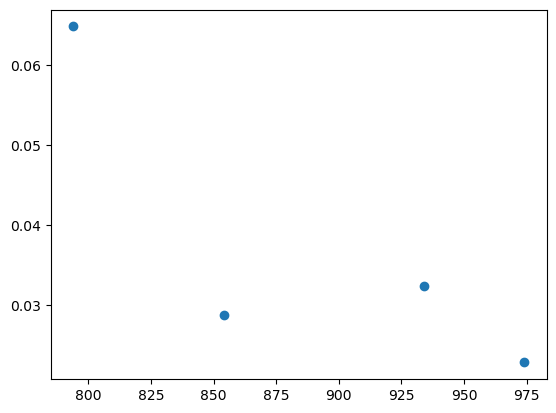

In [94]:
import matplotlib.pyplot as plt
plt.scatter(theoretical_times[indices], np.array(accs)[indices])
plt.show()

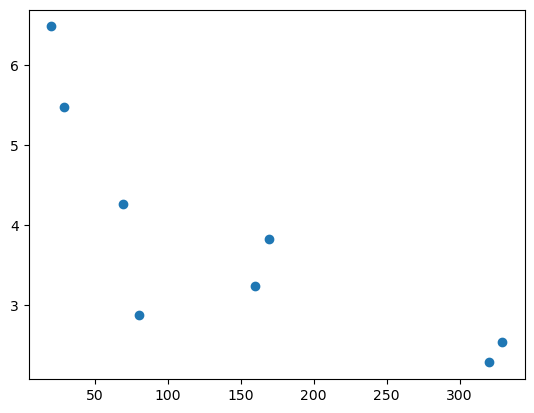

In [75]:
import matplotlib.pyplot as plt
plt.scatter(num_parameters, np.array(accs)*100)
plt.show()

In [48]:
run_path = "\\".join((path, folder))
folder = run_path.split("\\")[-1]
params = eval(folder.split("-")[-1])
params


[70, 10]

In [45]:
eval(folder.split("-")[1])

[70, 10]

In [31]:
new_dir

{'learning_data': {'train_loss': [0.33553973772113804,
   0.29316183807572743,
   0.27796080947097324,
   0.2669441950078242,
   0.256047032730619,
   0.246764031578674,
   0.23953578852742163,
   0.23351099968208208,
   0.22839536257505189,
   0.22410402012269545,
   0.21881316358701963,
   0.21561070961935666,
   0.21250979653157903,
   0.20938364969146656,
   0.20697142008219827,
   0.20414886735080492,
   0.20155714464623786,
   0.1984014983602008,
   0.19543489990930943,
   0.19333841259179177],
  'train_accuracy': [0.33553973772113804,
   0.29316183807572743,
   0.27796080947097324,
   0.2669441950078242,
   0.256047032730619,
   0.246764031578674,
   0.23953578852742163,
   0.23351099968208208,
   0.22839536257505189,
   0.22410402012269545,
   0.21881316358701963,
   0.21561070961935666,
   0.21250979653157903,
   0.20938364969146656,
   0.20697142008219827,
   0.20414886735080492,
   0.20155714464623786,
   0.1984014983602008,
   0.19543489990930943,
   0.19333841259179177],
 

In [23]:
np.array(data).T

array([[0.33553974, 0.29316184, 0.27796081, 0.2669442 , 0.25604703,
        0.24676403, 0.23953579, 0.233511  , 0.22839536, 0.22410402,
        0.21881316, 0.21561071, 0.2125098 , 0.20938365, 0.20697142,
        0.20414887, 0.20155714, 0.1984015 , 0.1954349 , 0.19333841],
       [0.09931667, 0.08668333, 0.082     , 0.07865   , 0.0752    ,
        0.07193333, 0.06926667, 0.06781667, 0.06611667, 0.06498333,
        0.06283333, 0.06233333, 0.06165   , 0.06088333, 0.06021667,
        0.0595    , 0.05893333, 0.05786667, 0.05695   , 0.05661667],
       [0.32485127, 0.28978367, 0.27897214, 0.27028384, 0.26093998,
        0.25291819, 0.24736394, 0.24259186, 0.23907805, 0.23634545,
        0.23163933, 0.22958437, 0.22772372, 0.22513499, 0.22317386,
        0.22132185, 0.21970841, 0.21747695, 0.21521535, 0.21412255],
       [0.0942    , 0.0866    , 0.083     , 0.0808    , 0.0775    ,
        0.075     , 0.0738    , 0.0728    , 0.0721    , 0.0708    ,
        0.0694    , 0.0693    , 0.0701    , 0

In [59]:
param =[10,10]
def run_quant_test(param, run_path): # assume for now you are given param
    network_parameters = [INPUT_SIZE, *params]
    base_model = NeuralNetwork().to(device)
    base_model.load_state_dict(torch.load("\\".join((run_path,"model.pth"))))
    loss_fn = nn.CrossEntropyLoss()
    
    train_dataloader = DataLoader(training_data, batch_size=batch_size)
    test_dataloader = DataLoader(test_data, batch_size=batch_size)

    for key in Q_all:
        q_test(test_dataloader, base_model, loss_fn, key)

    print('success')

run_quant_test(param, run_path)

NameError: name 'INPUT_SIZE' is not defined

In [28]:
from sld_NN_definitions import q_test


NameError: name 'DEBUG_MODE' is not defined

In [ ]:
# 8-bit quantized with scaling
print(gen_q_params(base_model, Qparam)[1])
Qparam = Fxp(-7.25, dtype='S1.7', rounding = 'around')
QX = Fxp(-7.25, dtype='U0.8', rounding = 'around')
Qa = Fxp(-7.25, dtype='U4.4', rounding = 'around')

q_test(test_dataloader, base_model, loss_fn, Qparam, QX, Qa)